In [1]:
import csv
import pandas as pd
import numpy as np
import string
import re
from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)
from trnlp import TrnlpWord
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models
import gensim
from gensim.models import TfidfModel
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import CoherenceModel

In [86]:
# Ekşi Sözlük'ten çektiğimiz veriyi python'a yükleyelim
data = pd.read_excel("TOGG_ALL.xlsx",header=None)
stop_words = pd.read_excel("guncel_durak.xlsx",header=None)
positive_words = pd.read_excel("guncel_pozitiff.xlsx",header=None)
negative_words = pd.read_excel("guncel_negatiff.xlsx",header=None)

data.columns = ['Togg yorumları']
positive_words.columns = ['positives']
negative_words.columns = ['negatives']
data.head()


,Togg yorumları
0,sevindiren gelişmedir. hayırlı olsun ülkemiz i...
1,seçim is coming.en az 1 milyon ortalama 1.5 mi...
2,yerli değil korosu sahneye çıkar.ülkenin imajı...
3,lan olm kaçıncıya açıyorsunuz bu fabrikayı? ge...
4,yıllardır yollarda olan arabamızın fabrikası s...


In [87]:
# noktalama işaretlerini ve büyük-küçük farkını ortadan kaldıralım, burada artık data cleaning yapıyoruz.
data["noktalamayok"] = data['Togg yorumları'].str.replace('[^\w\s]',' ')
data.head()

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
C:\Users\sozer\AppData\Local\Temp/ipykernel_6808/440328.py:2: DeprecationWarning: invalid escape sequence \w
  data["noktalamayok"] = data['Togg yorumları'].str.replace('[^\w\s]',' ')
C:\Users\sozer\AppData\Local\Temp/ipykernel_6808/440328.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data["noktalamayok"] = data['Togg yorumları'].str.replace('[^\w\s]',' ')


,Togg yorumları,noktalamayok
0,sevindiren gelişmedir. hayırlı olsun ülkemiz i...,sevindiren gelişmedir hayırlı olsun ülkemiz i...
1,seçim is coming.en az 1 milyon ortalama 1.5 mi...,seçim is coming en az 1 milyon ortalama 1 5 mi...
2,yerli değil korosu sahneye çıkar.ülkenin imajı...,yerli değil korosu sahneye çıkar ülkenin imajı...
3,lan olm kaçıncıya açıyorsunuz bu fabrikayı? ge...,lan olm kaçıncıya açıyorsunuz bu fabrikayı ge...
4,yıllardır yollarda olan arabamızın fabrikası s...,yıllardır yollarda olan arabamızın fabrikası s...


In [88]:
# küçük harfe çeviriyoruz
data['noktalamayok'] = data['noktalamayok'].str.lower()

In [89]:
# verimizde diğer önişleme süreçlerinde farklılığın ortadan kaldırılması adına Türkçe karakter farkını ortadan kaldıralım 
data['turkcekarakteryok'] = data['noktalamayok'].str.replace('ş','s')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ç','c')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ğ','g')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ı','i')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ü','u')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ö','o')


In [90]:
# aşağıdaki adımın kullanılıp kullanılmayacağına sonradan karar verilecek
#çünkü fiyatlamalar da önemli rol oynayabilir verisetinde
# data['sayisalyok'] = data['turkcekarakteryok'].str.replace("\d","")

In [91]:
# aşağıdaki kod satırında ise stop word'lerimizin bulunduğu dataframe'de yer alan kelimeleri data isimli dataframe'imizden kaldırıyoruz
data['no_stop_word'] = data['turkcekarakteryok'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words.values]))
data.head()

,Togg yorumları,noktalamayok,turkcekarakteryok,no_stop_word
0,sevindiren gelişmedir. hayırlı olsun ülkemiz i...,sevindiren gelişmedir hayırlı olsun ülkemiz i...,sevindiren gelismedir hayirli olsun ulkemiz i...,sevindiren gelismedir hayirli ulkemiz umarim u...
1,seçim is coming.en az 1 milyon ortalama 1.5 mi...,seçim is coming en az 1 milyon ortalama 1 5 mi...,secim is coming en az 1 milyon ortalama 1 5 mi...,secim coming 1 ortalama 1 5 tl satilacak araba...
2,yerli değil korosu sahneye çıkar.ülkenin imajı...,yerli değil korosu sahneye çıkar ülkenin imajı...,yerli degil korosu sahneye cikar ulkenin imaji...,yerli korosu sahneye cikar ulkenin imaji ekono...
3,lan olm kaçıncıya açıyorsunuz bu fabrikayı? ge...,lan olm kaçıncıya açıyorsunuz bu fabrikayı ge...,lan olm kacinciya aciyorsunuz bu fabrikayi ge...,lan olm kacinciya aciyorsunuz fabrikayi sene t...
4,yıllardır yollarda olan arabamızın fabrikası s...,yıllardır yollarda olan arabamızın fabrikası s...,yillardir yollarda olan arabamizin fabrikasi s...,yillardir yollarda arabamizin fabrikasi sonund...


In [92]:
# KNIME'da Zemberek POS Tagger ve Zemberek Stemmer kullanarak kelimeleri olabildiğince ek'lerinden ayırıyoruz ve 
# yalın haline getiriyoruz.
data = pd.read_excel("toggknime.xlsx",header=None)
data.columns=['Togg_yorumlari']
data['turkcekarakteryok'] = data['Togg_yorumlari'].str.replace('ş','s')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ç','c')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ğ','g')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ı','i')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ü','u')
data['turkcekarakteryok'] = data['turkcekarakteryok'].str.replace('ö','o')
data.head()

,Togg_yorumlari,turkcekarakteryok
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin gelis hayirli ulke um ure araba dunya i...
1,seçim coming ortalama tl satilacak arabanin fa...,secim coming ortalama tl satilacak arabanin fa...
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...
3,la olm kaçıncı aç fabrika sene tarih şey topl...,la olm kacinci ac fabrika sene tarih sey topl...
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,yil yol araba fabrika sonunda ekim insa bitir ...


In [93]:
# aşağıdak kod satirinda ise eğer 3 karakterden az kelimemiz bulunuyorsa kaldırıyorz, çünkü genelde
# Türkçe'de 3 kelimeden az kelimeler pek bir anlam ifade etmiyor. Zaten köklerini elde etmiştik.
data['karakterfiltreli'] = data['turkcekarakteryok'].apply(lambda x: ' '.join([word for word in str(x).split() if len(word)>3]))
data.head()

,Togg_yorumlari,turkcekarakteryok,karakterfiltreli
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin gelis hayirli ulke um ure araba dunya i...,sevin gelis hayirli ulke araba dunya ihrac
1,seçim coming ortalama tl satilacak arabanin fa...,secim coming ortalama tl satilacak arabanin fa...,secim coming ortalama satilacak arabanin fabri...
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...
3,la olm kaçıncı aç fabrika sene tarih şey topl...,la olm kacinci ac fabrika sene tarih sey topl...,kacinci fabrika sene tarih toplu toren
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,yil yol araba fabrika sonunda ekim insa bitir ...,araba fabrika sonunda ekim insa bitir ac…hava ...


In [94]:
#veride 3 kelimeden az olanları eledikten sonra tekrardan stop word'leri elimine etmek faydalı olabilir.
# Çünkü köküne ayırmadan önceki hali stop_word listesinde geçmeyebilir ve köküne ayırdıktan sonra stop_word'de bulunabilir.
# Bu sebepten dolayı tekrardan stop_word check'i yapmak faydalı olabilir.
data['stop_wordsuz'] = data['karakterfiltreli'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words.values]))
data.head()

,Togg_yorumlari,turkcekarakteryok,karakterfiltreli,stop_wordsuz
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin gelis hayirli ulke um ure araba dunya i...,sevin gelis hayirli ulke araba dunya ihrac,sevin gelis hayirli ulke araba ihrac
1,seçim coming ortalama tl satilacak arabanin fa...,secim coming ortalama tl satilacak arabanin fa...,secim coming ortalama satilacak arabanin fabri...,secim coming ortalama satilacak arabanin fabri...
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...
3,la olm kaçıncı aç fabrika sene tarih şey topl...,la olm kacinci ac fabrika sene tarih sey topl...,kacinci fabrika sene tarih toplu toren,kacinci fabrika sene toplu toren
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,yil yol araba fabrika sonunda ekim insa bitir ...,araba fabrika sonunda ekim insa bitir ac…hava ...,araba fabrika sonunda ekim insa bitir ac…hava ...


In [95]:
def word_tokenize(sentence):
    acronym_each_dot = r"(?:[a-zğçşöüı]\.){2,}"
    acronym_end_dot = r"\b[a-zğçşöüı]{2,3}\."
    suffixes = r"[a-zğçşöüı]{3,}' ?[a-zğçşöüı]{0,3}"
    numbers = r"\d+[.,:\d]+"
    any_word = r"[a-zğçşöüı]+"
    punctuations = r"[a-zğçşöüı]*[.,!?;:]"
    word_regex = "|".join([acronym_each_dot,acronym_end_dot,suffixes,numbers,any_word,punctuations])
    sentence = re.compile("%s"%word_regex, re.I).findall(sentence)
    return sentence

In [96]:
# Metnin boşluk, — , vb istenen özelliklere göre parçalara ayrılması işlemine tokenization adını veriyoruz.
# Aşağıdaki kod satırında da metinlerimize tokenization işlemi uygulayarak boşluğa göre ayırma işlemi gerçekleştiriyoruz ve kelimeleri
# elde ediyoruz. 
data['tokenized'] = data['stop_wordsuz'].apply(lambda x : word_tokenize(x))
data.head()

,Togg_yorumlari,turkcekarakteryok,karakterfiltreli,stop_wordsuz,tokenized
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin gelis hayirli ulke um ure araba dunya i...,sevin gelis hayirli ulke araba dunya ihrac,sevin gelis hayirli ulke araba ihrac,"[sevin, gelis, hayirli, ulke, araba, ihrac]"
1,seçim coming ortalama tl satilacak arabanin fa...,secim coming ortalama tl satilacak arabanin fa...,secim coming ortalama satilacak arabanin fabri...,secim coming ortalama satilacak arabanin fabri...,"[secim, coming, ortalama, satilacak, arabanin,..."
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,"[yerli, koro, sahne, cikar, ulke, imaj, ekonom..."
3,la olm kaçıncı aç fabrika sene tarih şey topl...,la olm kacinci ac fabrika sene tarih sey topl...,kacinci fabrika sene tarih toplu toren,kacinci fabrika sene toplu toren,"[kacinci, fabrika, sene, toplu, toren]"
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,yil yol araba fabrika sonunda ekim insa bitir ...,araba fabrika sonunda ekim insa bitir ac…hava ...,araba fabrika sonunda ekim insa bitir ac…hava ...,"[araba, fabrika, sonunda, ekim, insa, bitir, a..."


In [97]:
#Şimdi artık verimizi önişlemden geçirdik ve LDA yani Topic Modeling uygulayabiliriz.
#Tokenization işleminden geçirdiğimiz veriler üzerinden bir Gensim sözlüğü oluşturalım 
tokenized = data['tokenized']
#Her benzersiz terime bir dizin atanan korpus terim sözlüğü oluşturalım.
id2word = corpora.Dictionary(tokenized)
#1'den az olan ve %80'inden fazlasında bulunan kelimeleri/terimleri filtreleyelim. Çünkü bunlar genellikle anlamsız kelimelerdir.
id2word.filter_extremes(no_below=1, no_above=0.8)
# Sözlüğümüzü bir kelime torbasına çevirelim (bag of words)
corpus = [id2word.doc2bow(tokens) for tokens in tokenized]
print(corpus[:1])

2022-11-11 22:28:24,417 - gensim.corpora.dictionary - INFO
Msg: adding document #0 to Dictionary<0 unique tokens: []>

2022-11-11 22:28:24,582 - gensim.corpora.dictionary - INFO
Msg: built Dictionary<15025 unique tokens: ['araba', 'gelis', 'hayirli', 'ihrac', 'sevin']...> from 5814 documents (total 137827 corpus positions)

2022-11-11 22:28:24,583 - gensim.utils - INFO
Msg: Dictionary lifecycle event {'msg': "built Dictionary<15025 unique tokens: ['araba', 'gelis', 'hayirli', 'ihrac', 'sevin']...> from 5814 documents (total 137827 corpus positions)", 'datetime': '2022-11-11T22:28:24.583519', 'gensim': '4.2.0', 'python': '3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}

2022-11-11 22:28:24,587 - gensim.corpora.dictionary - INFO
Msg: discarding 0 tokens: []...

2022-11-11 22:28:24,588 - gensim.corpora.dictionary - INFO
Msg: keeping 15025 tokens which were in no less than 1 and no more than 4651 (=80.0%) doc

In [98]:
bigrams_phrases = gensim.models.Phrases(tokenized,min_count=5,threshold=50)
trigram_phrases = gensim.models.Phrases(bigrams_phrases[tokenized],threshold=50)
bigram = gensim.models.phrases.Phraser(bigrams_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams = make_bigrams(tokenized)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print(data_bigrams_trigrams[1])


2022-11-11 22:28:24,912 - gensim.models.phrases - INFO
Msg: collecting all words and their counts

2022-11-11 22:28:24,913 - gensim.models.phrases - INFO
Msg: PROGRESS: at sentence #0, processed 0 words and 0 word types

2022-11-11 22:28:25,068 - gensim.models.phrases - INFO
Msg: collected 110065 token types (unigram + bigrams) from a corpus of 137827 words and 5814 sentences

2022-11-11 22:28:25,070 - gensim.models.phrases - INFO
Msg: merged Phrases<110065 vocab, min_count=5, threshold=50, max_vocab_size=40000000>

2022-11-11 22:28:25,071 - gensim.utils - INFO
Msg: Phrases lifecycle event {'msg': 'built Phrases<110065 vocab, min_count=5, threshold=50, max_vocab_size=40000000> in 0.16s', 'datetime': '2022-11-11T22:28:25.071226', 'gensim': '4.2.0', 'python': '3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}

2022-11-11 22:28:25,074 - gensim.models.phrases - INFO
Msg: collecting all words and their counts

2

In [99]:
id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[4])

tfidf = TfidfModel(corpus, id2word=id2word)
low_value=0.03
words = []
words_missing_in_tfidf = []

for i in range(0,len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    

2022-11-11 22:28:26,520 - gensim.corpora.dictionary - INFO
Msg: adding document #0 to Dictionary<0 unique tokens: []>

2022-11-11 22:28:26,682 - gensim.corpora.dictionary - INFO
Msg: built Dictionary<15205 unique tokens: ['araba', 'gelis', 'hayirli', 'ihrac', 'sevin']...> from 5814 documents (total 134658 corpus positions)

2022-11-11 22:28:26,682 - gensim.utils - INFO
Msg: Dictionary lifecycle event {'msg': "built Dictionary<15205 unique tokens: ['araba', 'gelis', 'hayirli', 'ihrac', 'sevin']...> from 5814 documents (total 134658 corpus positions)", 'datetime': '2022-11-11T22:28:26.682187', 'gensim': '4.2.0', 'python': '3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'created'}

[(0, 1), (35, 3), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 2)]
2022-11-11 22:28:26,774 - gensim.models.tfidfmodel - INFO
Msg: collecting document frequencies

2022-11-11 22:28:26,775 - gensim.models.tfidf

In [130]:
#özellikle herhangi bir cümlede geçen kelimenin kaç kez tekrarlandığına bakalım, mesela cumhuriyet ve turki kelimeleri 2 kez geçmekte
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[11:12]]

[[('gelis', 2),
  ('ulke', 1),
  ('togg', 1),
  ('aday', 1),
  ('aksiyon', 1),
  ('alin', 1),
  ('bogaz', 1),
  ('ekseriyet', 1),
  ('girdi', 1),
  ('harika', 1),
  ('hatirl', 1),
  ('istemezuk', 1),
  ('kisacasi', 1),
  ('kopru', 1),
  ('kotule', 1),
  ('marmaray', 2),
  ('tayfa', 1),
  ('telafi', 1),
  ('vapur', 1),
  ('zaman', 3),
  ('zihniyet', 1)]]

In [101]:
#LDA
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                           num_topics = 5, 
                                           random_state=100,
                                           id2word=id2word,
                                            
                            
                                           passes=15,
                                           alpha='auto')
ldamodel.save('mOdel.gensim')
topics = ldamodel.print_topics(num_words=10) 

2022-11-11 22:28:28,364 - gensim.models.ldamodel - INFO
Msg: using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]

2022-11-11 22:28:28,365 - gensim.models.ldamodel - INFO
Msg: using symmetric eta at 0.2

2022-11-11 22:28:28,368 - gensim.models.ldamodel - INFO
Msg: using serial LDA version on this node

2022-11-11 22:28:28,377 - gensim.models.ldamodel - INFO
Msg: running online (multi-pass) LDA training, 5 topics, 15 passes over the supplied corpus of 5814 documents, updating model once every 2000 documents, evaluating perplexity every 5814 documents, iterating 50x with a convergence threshold of 0.001000

2022-11-11 22:28:28,378 - gensim.models.ldamodel - INFO
Msg: PROGRESS: pass 0, at document #2000/5814

2022-11-11 22:28:29,168 - gensim.models.ldamodel - INFO
Msg: optimized alpha [0.1634694, 0.18153381, 0.150597, 0.17192993, 0.15368453]

2022-11-11 22:28:29,172 - gensim.models.ldamodel - INFO
Msg: merging changes from 2000 documents into a model of 5814 documents

2022-11-1

In [102]:
# sonuçlara bakalım, hangi topiclerimiz mevcut
for topic in topics:
    print(topic,"\n")

(0, '0.020*"yerli" + 0.018*"proje" + 0.018*"ulke" + 0.016*"otomobil" + 0.011*"togg" + 0.011*"fabrika" + 0.011*"turkiye" + 0.011*"araba" + 0.011*"uretim" + 0.008*"sirket"') 

(1, '0.049*"arac" + 0.029*"araba" + 0.022*"fiyat" + 0.020*"elektrik" + 0.019*"togg" + 0.010*"piyasa" + 0.009*"model" + 0.009*"dusun" + 0.009*"para" + 0.009*"otomobil"') 

(2, '0.008*"otomobil" + 0.007*"test" + 0.006*"yerli" + 0.005*"uretim" + 0.005*"fabrika" + 0.005*"tasarim" + 0.005*"robot" + 0.004*"video" + 0.004*"togg" + 0.004*"yazilim"') 

(3, '0.029*"araba" + 0.020*"togg" + 0.011*"fabrika" + 0.007*"guzel" + 0.007*"millet" + 0.005*"adam" + 0.005*"kapi" + 0.004*"yerli" + 0.004*"secim" + 0.004*"logo"') 

(4, '0.006*"elektrik" + 0.006*"togg" + 0.004*"turki" + 0.004*"aracin" + 0.004*"arabayi" + 0.003*"model" + 0.003*"satis" + 0.003*"sene" + 0.003*"onemli" + 0.003*"tane"') 



In [103]:
#Doküman-Topic matrixi dokümanların topiclere dağılım olasılığını içeriyor. Hadi bu matrixi hangi dökümanın hangi topice ait olduğunu bulmak için kullanalım. 
get_document_topics = ldamodel.get_document_topics(corpus[0])
print(get_document_topics)

[(0, 0.8237361), (1, 0.13936995), (2, 0.010500773), (3, 0.018014746)]


In [104]:
#visualizing topics
lda_viz = gensim.models.ldamodel.LdaModel.load('mOdel.gensim')#load lda model
lda_display = pyLDAvis.gensim_models.prepare(lda_viz, corpus, id2word, sort_topics=True)
pyLDAvis.display(lda_display)

2022-11-11 22:28:59,892 - gensim.utils - INFO
Msg: loading LdaModel object from mOdel.gensim

2022-11-11 22:28:59,894 - gensim.utils - INFO
Msg: loading expElogbeta from mOdel.gensim.expElogbeta.npy with mmap=None

2022-11-11 22:28:59,895 - gensim.utils - INFO
Msg: setting ignored attribute id2word to None

2022-11-11 22:28:59,896 - gensim.utils - INFO
Msg: setting ignored attribute state to None

2022-11-11 22:28:59,896 - gensim.utils - INFO
Msg: setting ignored attribute dispatcher to None

2022-11-11 22:28:59,897 - gensim.utils - INFO
Msg: LdaModel lifecycle event {'fname': 'mOdel.gensim', 'datetime': '2022-11-11T22:28:59.897819', 'gensim': '4.2.0', 'python': '3.9.6 (default, Aug 18 2021, 15:44:49) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19044-SP0', 'event': 'loaded'}

2022-11-11 22:28:59,898 - gensim.utils - INFO
Msg: loading LdaState object from mOdel.gensim.state

2022-11-11 22:28:59,899 - gensim.utils - INFO
Msg: LdaState lifecycle event {'fname': 'mOdel.gensi

c:\Users\sozer\anaconda3\envs\ENV_NAME\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [105]:
def dominant_topic(ldamodel,corpus,content):
     #Function to find the dominant topic in each query
     sent_topics_df = pd.DataFrame() 
     # Get main topic in each query
     for i, row in enumerate(ldamodel[corpus]):
         row = sorted(row, key=lambda x: (x[1]), reverse=True)
         # Get the Dominant topic, Perc Contribution and Keywords for each query
         for j, (topic_num, prop_topic) in enumerate(row):
             if j == 0:  # => dominant topic
                 wp = ldamodel.show_topic(topic_num,topn=30)
                 topic_keywords = ", ".join([word for word, prop in wp])
                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
             else:
                 break
     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     contents = pd.Series(content)#noisy data
     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
     return(sent_topics_df)
df_dominant_topic = dominant_topic(ldamodel=ldamodel, corpus=corpus, content=data['stop_wordsuz']) 
df_dominant_topic.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,stop_wordsuz
0,0.0,0.8238,"yerli, proje, ulke, otomobil, togg, fabrika, t...",sevin gelis hayirli ulke araba ihrac
1,1.0,0.4855,"arac, araba, fiyat, elektrik, togg, piyasa, mo...",secim coming ortalama satilacak arabanin fabri...
2,0.0,0.6770,"yerli, proje, ulke, otomobil, togg, fabrika, t...",yerli koro sahne cikar ulke imaj ekonomi guzel...
3,3.0,0.8232,"araba, togg, fabrika, guzel, millet, adam, kap...",kacinci fabrika sene toplu toren
4,3.0,0.7887,"araba, togg, fabrika, guzel, millet, adam, kap...",araba fabrika sonunda ekim insa bitir ac…hava ...
5,3.0,0.7363,"araba, togg, fabrika, guzel, millet, adam, kap...",maalesef hayal kirik aday
6,0.0,0.5515,"yerli, proje, ulke, otomobil, togg, fabrika, t...",yerli milli dusman ilan sene ucak uzay mekig t...
7,3.0,0.7157,"araba, togg, fabrika, guzel, millet, adam, kap...",eksi kardes camur kafa patla tanim mutlu tane
8,0.0,0.4723,"yerli, proje, ulke, otomobil, togg, fabrika, t...",togg bikkin getir gelis ekonomi ozel sektor ar...
9,0.0,0.5150,"yerli, proje, ulke, otomobil, togg, fabrika, t...",turkiye adim cumhuriyet ilan anlam onem denk g...


In [106]:
df_dominant_topic.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,stop_wordsuz
0,0.0,0.8238,"yerli, proje, ulke, otomobil, togg, fabrika, t...",sevin gelis hayirli ulke araba ihrac
1,1.0,0.4855,"arac, araba, fiyat, elektrik, togg, piyasa, mo...",secim coming ortalama satilacak arabanin fabri...
2,0.0,0.6770,"yerli, proje, ulke, otomobil, togg, fabrika, t...",yerli koro sahne cikar ulke imaj ekonomi guzel...
3,3.0,0.8232,"araba, togg, fabrika, guzel, millet, adam, kap...",kacinci fabrika sene toplu toren
4,3.0,0.7887,"araba, togg, fabrika, guzel, millet, adam, kap...",araba fabrika sonunda ekim insa bitir ac…hava ...
5,3.0,0.7363,"araba, togg, fabrika, guzel, millet, adam, kap...",maalesef hayal kirik aday
6,0.0,0.5515,"yerli, proje, ulke, otomobil, togg, fabrika, t...",yerli milli dusman ilan sene ucak uzay mekig t...
7,3.0,0.7157,"araba, togg, fabrika, guzel, millet, adam, kap...",eksi kardes camur kafa patla tanim mutlu tane
8,0.0,0.4723,"yerli, proje, ulke, otomobil, togg, fabrika, t...",togg bikkin getir gelis ekonomi ozel sektor ar...
9,0.0,0.5150,"yerli, proje, ulke, otomobil, togg, fabrika, t...",turkiye adim cumhuriyet ilan anlam onem denk g...


In [107]:
data = pd.concat([data,df_dominant_topic.iloc[:,0:3]],axis=1,join='outer')

In [108]:
data = data.drop(columns=['karakterfiltreli'])
data.head()

,Togg_yorumlari,turkcekarakteryok,stop_wordsuz,tokenized,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin gelis hayirli ulke um ure araba dunya i...,sevin gelis hayirli ulke araba ihrac,"[sevin, gelis, hayirli, ulke, araba, ihrac]",0.0,0.8238,"yerli, proje, ulke, otomobil, togg, fabrika, t..."
1,seçim coming ortalama tl satilacak arabanin fa...,secim coming ortalama tl satilacak arabanin fa...,secim coming ortalama satilacak arabanin fabri...,"[secim, coming, ortalama, satilacak, arabanin,...",1.0,0.4855,"arac, araba, fiyat, elektrik, togg, piyasa, mo..."
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,"[yerli, koro, sahne, cikar, ulke, imaj, ekonom...",0.0,0.6770,"yerli, proje, ulke, otomobil, togg, fabrika, t..."
3,la olm kaçıncı aç fabrika sene tarih şey topl...,la olm kacinci ac fabrika sene tarih sey topl...,kacinci fabrika sene toplu toren,"[kacinci, fabrika, sene, toplu, toren]",3.0,0.8232,"araba, togg, fabrika, guzel, millet, adam, kap..."
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,yil yol araba fabrika sonunda ekim insa bitir ...,araba fabrika sonunda ekim insa bitir ac…hava ...,"[araba, fabrika, sonunda, ekim, insa, bitir, a...",3.0,0.7887,"araba, togg, fabrika, guzel, millet, adam, kap..."


In [109]:
#data['deneme'] = ["Long" if ele  == "BULL" else "Short" for satir in data["stop_wordsuz"]]

In [110]:
positives_2=[]
negatives_2=[]
for i in range(data.shape[0]):
    negative_sayac=0
    positive_sayac=0
    for word in data.tokenized[i]:
        if word in negative_words.values:
            negative_sayac+=1
        elif word in positive_words.values:
            positive_sayac+=1
    positives_2.append(positive_sayac)
    negatives_2.append(negative_sayac)        

In [111]:
data['positive_sayac'] = positives_2
data['negative_sayac'] = negatives_2
def f(row):
    if row['positive_sayac'] == row['negative_sayac']:
        val = "nötr"
    elif row['positive_sayac'] > row['negative_sayac']:
        val = "pozitif"
    else:
        val = "negatif"
    return val
data['sentiment'] = data.apply(f, axis=1)
data

,Togg_yorumlari,turkcekarakteryok,stop_wordsuz,tokenized,Dominant_Topic,Perc_Contribution,Topic_Keywords,positive_sayac,negative_sayac,sentiment
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin gelis hayirli ulke um ure araba dunya i...,sevin gelis hayirli ulke araba ihrac,"[sevin, gelis, hayirli, ulke, araba, ihrac]",0.0,0.8238,"yerli, proje, ulke, otomobil, togg, fabrika, t...",1,0,pozitif
1,seçim coming ortalama tl satilacak arabanin fa...,secim coming ortalama tl satilacak arabanin fa...,secim coming ortalama satilacak arabanin fabri...,"[secim, coming, ortalama, satilacak, arabanin,...",1.0,0.4855,"arac, araba, fiyat, elektrik, togg, piyasa, mo...",1,1,nötr
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,"[yerli, koro, sahne, cikar, ulke, imaj, ekonom...",0.0,0.6770,"yerli, proje, ulke, otomobil, togg, fabrika, t...",1,0,pozitif
3,la olm kaçıncı aç fabrika sene tarih şey topl...,la olm kacinci ac fabrika sene tarih sey topl...,kacinci fabrika sene toplu toren,"[kacinci, fabrika, sene, toplu, toren]",3.0,0.8232,"araba, togg, fabrika, guzel, millet, adam, kap...",0,0,nötr
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,yil yol araba fabrika sonunda ekim insa bitir ...,araba fabrika sonunda ekim insa bitir ac…hava ...,"[araba, fabrika, sonunda, ekim, insa, bitir, a...",3.0,0.7887,"araba, togg, fabrika, guzel, millet, adam, kap...",0,0,nötr
...,...,...,...,...,...,...,...,...,...,...
5809,bari panelvanını yap inovatif enişte hitap et,bari panelvanini yap inovatif eniste hitap et,bari panelvanini inovatif eniste hitap,"[bari, panelvanini, inovatif, eniste, hitap]",2.0,0.6607,"otomobil, test, yerli, uretim, fabrika, tasari...",0,0,nötr
5810,fatih altaylı bura halt jaws atla içer aktar...,fatih altayli bura halt jaws atla icer aktar...,fatih altayli bura halt jaws atla icer aktar a...,"[fatih, altayli, bura, halt, jaws, atla, icer,...",0.0,0.4459,"yerli, proje, ulke, otomobil, togg, fabrika, t...",8,6,pozitif
5811,üretim band video paylaş kapasite başla seda...,uretim band video paylas kapasite basla seda...,uretim band video paylas kapasite seda model g...,"[uretim, band, video, paylas, kapasite, seda, ...",1.0,0.9416,"arac, araba, fiyat, elektrik, togg, piyasa, mo...",0,1,negatif
5812,mustafa koç ticari intihar söylem katıl pazar ...,mustafa koc ticari intihar soylem katil pazar ...,mustafa ticari intihar soylem katil pazar yara...,"[mustafa, ticari, intihar, soylem, katil, paza...",0.0,0.5654,"yerli, proje, ulke, otomobil, togg, fabrika, t...",6,2,pozitif


In [112]:
data.head()

,Togg_yorumlari,turkcekarakteryok,stop_wordsuz,tokenized,Dominant_Topic,Perc_Contribution,Topic_Keywords,positive_sayac,negative_sayac,sentiment
0,sevin geliş hayırlı ülke um üre araba dünya i...,sevin gelis hayirli ulke um ure araba dunya i...,sevin gelis hayirli ulke araba ihrac,"[sevin, gelis, hayirli, ulke, araba, ihrac]",0.0,0.8238,"yerli, proje, ulke, otomobil, togg, fabrika, t...",1,0,pozitif
1,seçim coming ortalama tl satilacak arabanin fa...,secim coming ortalama tl satilacak arabanin fa...,secim coming ortalama satilacak arabanin fabri...,"[secim, coming, ortalama, satilacak, arabanin,...",1.0,0.4855,"arac, araba, fiyat, elektrik, togg, piyasa, mo...",1,1,nötr
2,yerli koro sahne çıkar ülke imaj ekonomi güzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,yerli koro sahne cikar ulke imaj ekonomi guzel...,"[yerli, koro, sahne, cikar, ulke, imaj, ekonom...",0.0,0.6770,"yerli, proje, ulke, otomobil, togg, fabrika, t...",1,0,pozitif
3,la olm kaçıncı aç fabrika sene tarih şey topl...,la olm kacinci ac fabrika sene tarih sey topl...,kacinci fabrika sene toplu toren,"[kacinci, fabrika, sene, toplu, toren]",3.0,0.8232,"araba, togg, fabrika, guzel, millet, adam, kap...",0,0,nötr
4,yıl yol araba fabrika sonunda ekim inşa bitir ...,yil yol araba fabrika sonunda ekim insa bitir ...,araba fabrika sonunda ekim insa bitir ac…hava ...,"[araba, fabrika, sonunda, ekim, insa, bitir, a...",3.0,0.7887,"araba, togg, fabrika, guzel, millet, adam, kap...",0,0,nötr


In [113]:
#topic_keywords = data.Topic_Keywords.value_counts().to_frame()
topic_keywords = data[['Dominant_Topic','Topic_Keywords','sentiment']]
#topic_keywords = topic_keywords.reset_index()
#topic_keywords.columns=['Dominant_Topic','Topic_Keywords']
topic_keywords = topic_keywords.groupby(by=['Dominant_Topic']).Topic_Keywords.value_counts().to_frame()
topic_keywords

,,Topic_Keywords
Dominant_Topic,Topic_Keywords,
0.0,"yerli, proje, ulke, otomobil, togg, fabrika, turkiye, araba, uretim, sirket, muhendis, insan, milli, buyuk, basari, konu, yatirim, firma, devlet, adam, zaman, para, turk, arac, urun, onem, tasarim, anla, parca, teknoloji",1739
1.0,"arac, araba, fiyat, elektrik, togg, piyasa, model, dusun, para, otomobil, yerli, vergi, uretim, dolar, kullan, ucuz, turkiye, ulke, zaman, maliyet, lira, tesla, motor, batarya, halk, sene, pazar, durum, konu, devlet",2953
2.0,"otomobil, test, yerli, uretim, fabrika, tasarim, robot, video, togg, yazilim, insaat, arka, guzel, konsept, bagaj, ekip, euro_ncap, pininfarina, goruntu, soru, yayinla, sosyal_medya, kalip, tane, bayil, araba, ekib, cevap, gorsel, murat_gunak",280
3.0,"araba, togg, fabrika, guzel, millet, adam, kapi, yerli, secim, logo, gurur, ulke, izle, muhalif, haber, begen, yalan, milli, sene, hayirli, allah, para, parti, devrim, kardes, pazar_gecir, ekim, fuar, devam, cikar",646
4.0,"elektrik, togg, turki, aracin, arabayi, model, satis, sene, onemli, tane, fiyati, adam, arabanin, tesla, devlet, markasi, araclari, ford, ayar, araci, yeni, konu, calisan, piyasa, firma, baki, uretimi, umarim, dunyada, otomotiv",196


In [114]:
data_group_topics = data.groupby(by=['Dominant_Topic']).sentiment.value_counts().to_frame()
#.sentiment.value_counts()
#data_group_topics.unstack()
data_group_topics
data_group_topics['yuzde'] = data_group_topics.groupby(level=0).transform(lambda x: (x / x.sum()).round(2))
data_group_topics

sentiment  yuzde
Dominant_Topic sentiment                  
0.0            pozitif          892   0.51
               nötr             588   0.34
               negatif          259   0.15
1.0            nötr            1258   0.43
               pozitif         1250   0.42
               negatif          445   0.15
2.0            nötr             146   0.52
               pozitif          100   0.36
               negatif           34   0.12
3.0            nötr             296   0.46
               pozitif          245   0.38
               negatif          105   0.16
4.0            pozitif           78   0.40
               nötr              75   0.38
               negatif           43   0.22

In [115]:
data.sentiment.value_counts()
data_group_topics_2 = data.groupby(by=['sentiment']).Togg_yorumlari.count().to_frame()
data_group_topics_2['yuzde'] = data_group_topics_2.transform(lambda x: (x / x.sum()).round(4))
data_group_topics_2

,Togg_yorumlari,yuzde
sentiment,,
negatif,886,0.1533
nötr,2328,0.4028
pozitif,2565,0.4438


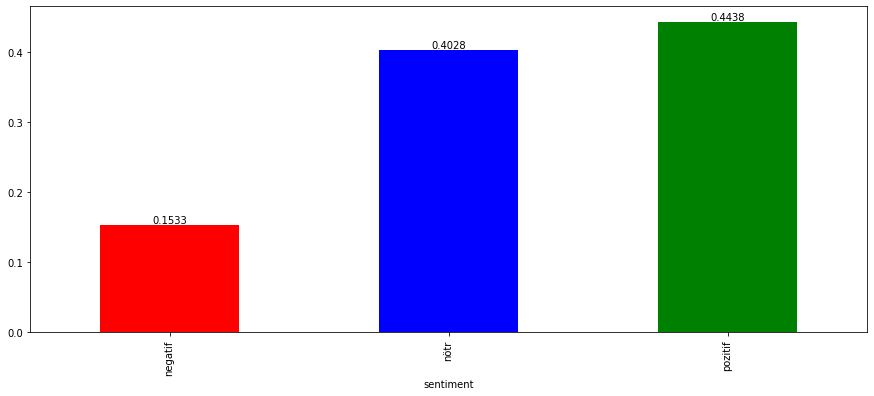

In [116]:
graf_2 = data_group_topics_2.yuzde.plot(kind='bar', stacked=False,color=['r','b','g'],figsize=(15,6))
for deger in graf_2.containers:
    graf_2.bar_label(deger)

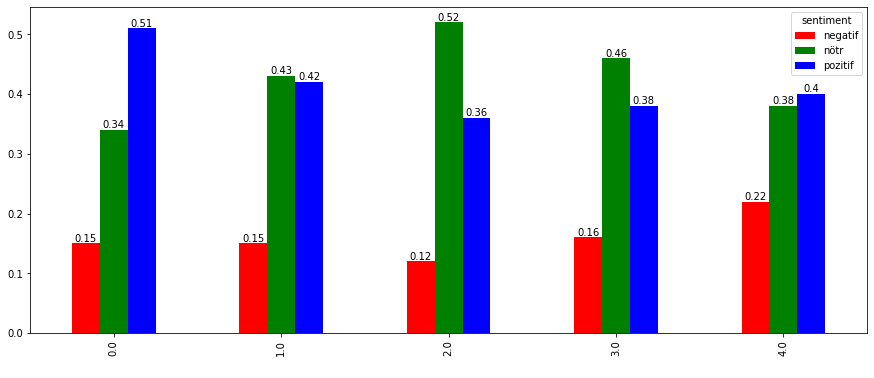

In [117]:
#pd.concat([data_group_topics,topic_keywords])
graf = data_group_topics.unstack().yuzde.plot(kind='bar', stacked=False,color=['r','g','b'],figsize=(15,6))
for deger in graf.containers:
    graf.bar_label(deger)
graf.xaxis.label.set_color('white')

In [118]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic,20)}
    wc = WordCloud(background_color="white", max_words=1000,width=1800,height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()

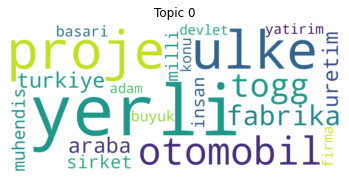

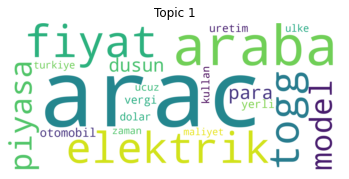

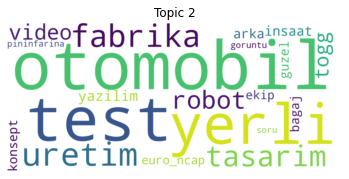

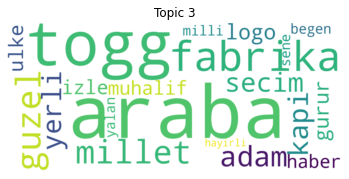

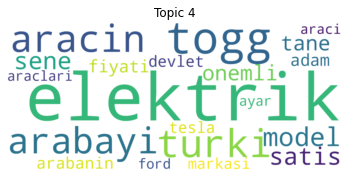

In [119]:
from wordcloud import WordCloud
num_topics = 5

for i in range(0,num_topics):
    create_wordcloud(ldamodel, topic=i)